In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [41]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]
    return parameters

In [42]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size*k:mini_batch_size*(k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k:mini_batch_size*(k+1)]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: m]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [55]:
def initialize_velocity(parameters):
    L = len(parameters)//2
    v = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    return v

In [62]:
def update_parameters_with_momentum(parameters, grads, v, beta,learning_rate):
    L = len(parameters)//2
    for l in range(L):
        v['dW' + str(l+1)] = beta * v['dW' + str(l+1)] + (1-beta)*grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta * v['db' + str(l+1)] + (1-beta)*grads['db' + str(l+1)]
        
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v['db' + str(l+1)]
    return parameters, v

In [65]:
def initialize_adam(parameters):
    L = len(parameters)//2
    v = {}
    s = {}
    for l in range(L):
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        
    return v,s

In [70]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999,epsilon=1e-8):
    L = len(parameters)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = beta1*v['dW'+str(l+1)] + (1-beta1)*grads['dW'+str(l+1)]
        v['db' + str(l+1)] = beta1*v['db'+str(l+1)] + (1-beta1)*grads['db'+str(l+1)]
        v_corrected['dW' + str(l+1)] = v['dW'+str(l+1)]/(1-math.pow(beta1,t))
        v_corrected['db' + str(l+1)] = v['db'+str(l+1)]/(1-math.pow(beta1,t))
        
        s['dW' + str(l+1)] = beta2*s['dW'+str(l+1)] + (1-beta2)*grads['dW'+str(l+1)]
        s['db' + str(l+1)] = beta2*s['db'+str(l+1)] + (1-beta2)*grads['db'+str(l+1)]
        s_corrected['dW' + str(l+1)] = s['dW'+str(l+1)]/(1-math.pow(beta2,t))
        s_corrected['db' + str(l+1)] = s['db'+str(l+1)]/(1-math.pow(beta2,t))
        
        parameters['W'+str(l+1)]=parameters['W'+str(l+1)]-learning_rate*v_corrected['dW'+str(l+1)]/ \
                                 (np.sqrt(s_corrected['dW'+str(l+1)])+epsilon)
        parameters['b'+str(l+1)]=parameters['b'+str(l+1)]-learning_rate*v_corrected['db'+str(l+1)]/ \
                                 (np.sqrt(s_corrected['db'+str(l+1)])+epsilon)
    return parameters, v, s
                                 

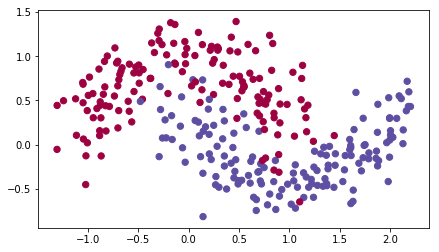

In [59]:
train_X, train_Y = load_dataset()

In [60]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,mini_batch_size=64,beta=0.9,beta1=0.9, beta2=0.999, \
          epsilon=1e-8,num_epochs=10000,print_cost=True):
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    
    parameters = initialize_parameters(layers_dims)
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == 'momentum':
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam':
                t = t+1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        if print_cost and i%1000 == 0:
            print('Cost after epoch %i: %f' %(i,cost))
        if print_cost and i%100 == 0:
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()
    
    return parameters

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


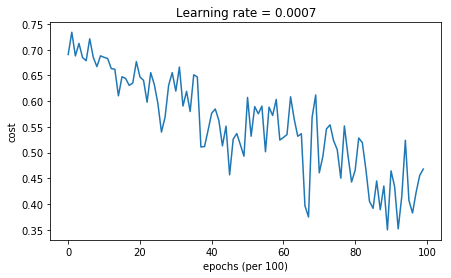

Accuracy: 0.7966666666666666


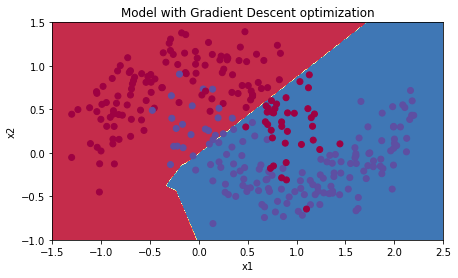

In [50]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = 'gd')

predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters,x.T), train_X, np.squeeze(train_Y))

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


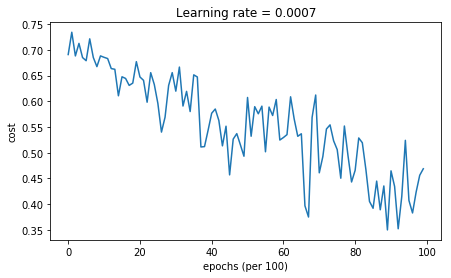

Accuracy: 0.7966666666666666


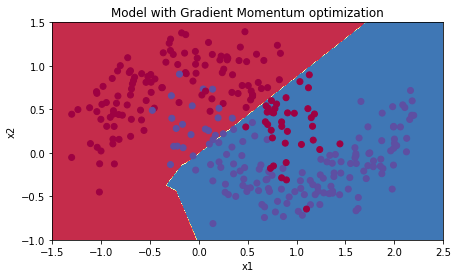

In [63]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = 'momentum')

predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Gradient Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters,x.T), train_X, np.squeeze(train_Y))

/home/cb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/home/cb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/cb/deeplearning/source2/week2/opt_utils.py:159: RuntimeWarning: invalid value encountered in greater
  dz2 = np.multiply(da2, np.int64(a2 > 0))
/home/cb/deeplearning/source2/week2/opt_utils.py:164: RuntimeWarning: invalid value encountered in greater
  dz1 = np.multiply(da1, np.int64(a1 > 0))


Cost after epoch 0: nan
Cost after epoch 1000: nan
Cost after epoch 2000: nan
Cost after epoch 3000: nan
Cost after epoch 4000: nan
Cost after epoch 5000: nan
Cost after epoch 6000: nan
Cost after epoch 7000: nan
Cost after epoch 8000: nan
Cost after epoch 9000: nan


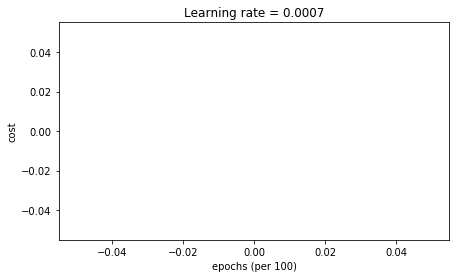

Accuracy: 0.5


/home/cb/deeplearning/source2/week2/opt_utils.py:249: RuntimeWarning: invalid value encountered in greater
  predictions = (a3 > 0.5)


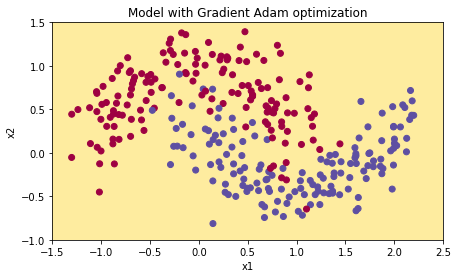

In [71]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer = 'adam')

predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Gradient Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters,x.T), train_X, np.squeeze(train_Y))